# Generating text inspired from Blizzard's Warcraft Franchise

In [277]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re

text = open('WC3.txt', 'rb').read().decode(encoding='utf-8')
print(f"Length of text: {len(text)} characters")

#replace all non alphabetic characters with space
non_alphabetic = [',', '.', '!', '?', '-', ':', ';', '(', ')', '[', ']', '{', '}', '\n', '\r', '\t', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\x19']
for i in non_alphabetic:
    text = text.replace(i, ' ')
    
def remove_nonprintable_characters(text):
    # Define the regular expression pattern to match non-printable characters
    pattern = r'[^\x00-\x7F]|\x1B|\x00-\x08|\x0B\x0C|\x0E-\x1F|\x7F|\x80-\xFF'

    # Use re.sub to replace the matched pattern with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

text = remove_nonprintable_characters(text)

end_token = " <END> "  # Make sure to include spaces around the token
text = text.replace(".", "." + end_token)


Length of text: 747168 characters


In [278]:
# check which device is available for tensorflow
tf.test.gpu_device_name()

'/device:GPU:0'

In [279]:
# Inspect how many unique characters appear throughout the supplied script/text data
unique_chars = sorted(set(text))
print(f"{len(unique_chars)} unique characters")
print(unique_chars)

56 unique characters
[' ', '"', '&', "'", '/', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [280]:
# Test Characters to demonstrate ids_from_chars
test_chars = ['arthas', 'illidan']
test_chars = tf.strings.unicode_split(test_chars, input_encoding='UTF-8')

# Create a mapping from unique characters to indices
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(unique_chars), mask_token=None)

# Check that the ids were assigned correctly
ids = ids_from_chars(test_chars)
ids


<tf.RaggedTensor [[31, 48, 50, 38, 31, 49], [39, 42, 42, 39, 34, 31, 44]]>

In [281]:
# Create a mapping from indices to characters
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

# Test on encoded examples
test_chars = chars_from_ids(ids)
test_chars

<tf.RaggedTensor [[b'a', b'r', b't', b'h', b'a', b's'],
 [b'i', b'l', b'l', b'i', b'd', b'a', b'n']]>

In [282]:
# Function to convert ids back to human readable text
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [283]:
#  Create a dataset of the encoded text
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(740775,), dtype=int64, numpy=array([14, 44, 50, ..., 37,  1,  1], dtype=int64)>

In [284]:
# Covert the text vector into a stream of character indices
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
ids_dataset

# Denote the sequence length for each input sequence
seq_length = 50
examples_per_epoch = len(text) // (seq_length + 1)

# Use batch method to convert the individual characters into sequences of the desired size
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)

# Test the batch method
for seq in sequences.take(2):
    print(chars_from_ids(seq))
    
# Covert back to human readable text
for seqq in sequences.take(2):
    print(text_from_ids(seqq).numpy())


tf.Tensor(
[b'I' b'n' b't' b'r' b'o' b'd' b'u' b'c' b't' b'i' b'o' b'n' b' ' b'M'
 b'o' b'v' b'i' b'e' b' ' b' ' b' ' b' ' b'N' b'a' b'r' b'r' b'a' b't'
 b'o' b'r' b' ' b' ' b'T' b'h' b'e' b' ' b's' b'a' b'n' b'd' b's' b' '
 b'o' b'f' b' ' b't' b'i' b'm' b'e' b' ' b'h'], shape=(51,), dtype=string)
tf.Tensor(
[b'a' b'v' b'e' b' ' b'r' b'u' b'n' b' ' b'o' b'u' b't' b' ' b' ' b's'
 b'o' b'n' b' ' b'o' b'f' b' ' b'D' b'u' b'r' b'o' b't' b'a' b'n' b' '
 b' ' b' ' b'C' b'r' b'i' b'e' b's' b' ' b'o' b'f' b' ' b'w' b'a' b'r'
 b' ' b' ' b'e' b'c' b'h' b'o' b' ' b' ' b' '], shape=(51,), dtype=string)
b'Introduction Movie    Narrator  The sands of time h'
b'ave run out  son of Durotan   Cries of war  echo   '


In [285]:
# Split the sequences into input and target offsetting by one character
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Test the split_input_target function
split_input_target(list("Arthas my boy"))

(['A', 'r', 't', 'h', 'a', 's', ' ', 'm', 'y', ' ', 'b', 'o'],
 ['r', 't', 'h', 'a', 's', ' ', 'm', 'y', ' ', 'b', 'o', 'y'])

In [286]:
# Preprocess the text data to generate input and target text strings
dataset = sequences.map(split_input_target)

# Text the dataset
for x,y in dataset.take(1):
    print("Input: ", text_from_ids(x).numpy())
    print("Target: ", text_from_ids(y).numpy())

Input:  b'Introduction Movie    Narrator  The sands of time '
Target:  b'ntroduction Movie    Narrator  The sands of time h'


In [287]:
# Split the data into managable sequences, assigning batch size and shuffling the data.
BATCH_SIZE = 64
BUFFER_SIZE = 100000

dataset = (
    dataset.shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int64, name=None), TensorSpec(shape=(64, 50), dtype=tf.int64, name=None))>

In [288]:
# Assign initial parameters
# Length of the vocabulary in chars
vocab_size = len(unique_chars)
print(vocab_size)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

56


In [289]:
# Build the model using a tf.keras.Model class
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super(MyModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        # Add attention layer
        self.attention = tf.keras.layers.AdditiveAttention()
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, inputs, states=None, return_state=False, training=False, mask=None):
        x = self.embedding(inputs, training=training)
        # If no previous state, initialize the state
        if states is None:
            states = self.gru.get_initial_state(x)
            
        x, states = self.gru(x, initial_state=states, training=training)

        # print(x)
        query = states
        query = tf.tile(tf.expand_dims(query, axis=1), [1, tf.shape(x)[1], 1])

        # Update to include the output of the attention layer
        context_vector, attention_scores = self.attention([query, x], return_attention_scores=True)
        x = tf.concat([context_vector, x], axis=-1)

        x = self.dense(x, training=training)

        if return_state:
            return x, states, attention_scores
        else:
            return x

In [290]:
model = MyModel(
    # Assure the vocabulary size matches the StringLookup layers
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

# model.build(input_shape=(BATCH_SIZE, seq_length))
# model.summary()

In [291]:
for input_example_batch, target_example_batch in dataset.take(1):
    print("Input shape:", input_example_batch.shape)
    print(input_example_batch)
    print("Target shape:", target_example_batch.shape)
    print(target_example_batch)
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape: (64, 50)
tf.Tensor(
[[ 1 38 35 ... 49  1 32]
 [44  1 53 ... 45 48 50]
 [37 38 50 ... 32 35 35]
 ...
 [51 42 34 ... 38 39 44]
 [41  1 31 ... 35 34  1]
 [48 43 51 ...  1  1  6]], shape=(64, 50), dtype=int64)
Target shape: (64, 50)
tf.Tensor(
[[38 35  1 ...  1 32 48]
 [ 1 53 45 ... 48 50 38]
 [38 50  1 ... 35 35 44]
 ...
 [42 34  1 ... 39 44 37]
 [ 1 31 44 ... 34  1 38]
 [43 51 48 ...  1  6 44]], shape=(64, 50), dtype=int64)
(64, 50, 57) # (batch_size, sequence_length, vocab_size)


In [292]:
sampled_indices = tf.random.categorical(
    example_batch_predictions[0], num_samples=1
)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

sampled_indices

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' he found himself with her in his arms  her eyes b'

Next Char Predictions:
 b"'shYJGSQwTmUqV/ fGBlYjkawnb'EunnJiG'BuzdXijRguxYaQ"


In [293]:
# Model Summary to check the model architecture
model.build(input_shape=(BATCH_SIZE,seq_length))
model.summary()

Model: "my_model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     multiple                  14592     
                                                                 
 gru_9 (GRU)                 multiple                  3938304   
                                                                 
 additive_attention_9 (Addit  multiple                 1024      
 iveAttention)                                                   
                                                                 
 dense_9 (Dense)             multiple                  116793    
                                                                 
Total params: 4,070,713
Trainable params: 4,070,713
Non-trainable params: 0
_________________________________________________________________


In [294]:
# Assign a loss function to the model
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [295]:
# # Compile the model with the loss function
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss=loss)

In [296]:
# Create a directory to save the model checkpoints
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Only save every 10th epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    period=10
)

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True,
    min_delta = 0.001
)


In [297]:
# Set the epochs
EPOCHS = 2

# Define the loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define metrics to track during training
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions= model(inputs, training=True)
        # Compute loss
        loss = loss_object(targets, predictions)
    
    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update metrics
    train_loss(loss)

# Training loop
for epoch in range(EPOCHS):
    # Reset metrics at the beginning of each epoch
    train_loss.reset_states()
    
    # Iterate over the dataset
    for inputs, targets in dataset:
        print(inputs)
        # Perform a training step
        train_step(inputs, targets)
    
    # Print the training loss for each epoch
    print(f'Epoch {epoch+1}, Loss: {train_loss.result()}')
    
    # Save the model checkpoints
    if (epoch + 1) % 10 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch+1))
    

tf.Tensor(
[[50 38 35 ...  1 37 48]
 [ 1  6 48 ...  1 31 48]
 [39 48 42 ... 48 49 35]
 ...
 [44 34  1 ...  1 50 45]
 [44  1 38 ... 31 34  1]
 [ 1 42 35 ... 51 48 39]], shape=(64, 50), dtype=int64)
tf.Tensor(
[[35  1 51 ... 50 38 39]
 [42  1 46 ... 49 50 35]
 [38 39 44 ... 53 35 31]
 ...
 [38  1  1 ...  1 49 38]
 [49  1 31 ... 39 46 46]
 [51 42  1 ... 48 31 44]], shape=(64, 50), dtype=int64)
tf.Tensor(
[[ 1 31  1 ...  1 43 35]
 [31 52 35 ... 28 39 44]
 [ 1 31 44 ... 44 33 38]
 ...
 [36 51 42 ...  6 42 42]
 [ 1 42 31 ... 45 36  1]
 [44 45 53 ...  1  1 32]], shape=(64, 50), dtype=int64)
tf.Tensor(
[[35 50  1 ...  1  1 42]
 [34  1 32 ... 45 50  1]
 [32 48 45 ...  1 36 35]
 ...
 [53  1  1 ... 44 37  1]
 [39 50 38 ...  1 31 33]
 [ 1 50 53 ... 46 51 49]], shape=(64, 50), dtype=int64)
tf.Tensor(
[[52 35 44 ...  1 50 38]
 [ 1 38 39 ... 49 45 51]
 [34  1  1 ... 45 51  1]
 ...
 [ 1 31 42 ... 35 34  1]
 [49 42 35 ... 46 35 31]
 [35 44 37 ... 44 37 35]], shape=(64, 50), dtype=int64)
tf.Tensor(
[[35

In [298]:
for input_example_batch, target_example_batch in dataset.take(1):
    #print("Input shape:", input_example_batch.shape)
    #print(input_example_batch)
    #print("Target shape:", target_example_batch.shape)
    #print(target_example_batch)
    example_batch_predictions = model(input_example_batch)
    #print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    
sampled_indices = tf.random.categorical(
    example_batch_predictions[0], num_samples=1
)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

sampled_indices

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'n flowing white robes stood still and poised  Some'

Next Char Predictions:
 b'diiowang tarmh Oese  tpikdstoill  nd solla  otHmes'


Generated Text:
Arthus ArAAAAAAAAAAAAAAAAA
[<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0.09961536, 0.15379553, 0.27940193, 0.11859491, 0.04788506,
         0.3007072 ],
        [0.09961536, 0.15379553, 0.27940193, 0.11859491, 0.04788506,
         0.3007072 ],
        [0.09961536, 0.15379553, 0.27940193, 0.11859491, 0.04788506,
         0.3007072 ],
        [0.09961536, 0.15379553, 0.27940193, 0.11859491, 0.04788506,
         0.3007072 ],
        [0.09961536, 0.15379553, 0.27940193, 0.11859491, 0.04788506,
         0.3007072 ],
        [0.09961536, 0.15379553, 0.27940193, 0.11859491, 0.04788506,
         0.3007072 ]]], dtype=float32)>, <tf.Tensor: shape=(1, 7, 7), dtype=float32, numpy=
array([[[0.07769602, 0.17550157, 0.2861847 , 0.09741302, 0.0356187 ,
         0.2866567 , 0.04092926],
        [0.07769602, 0.17550157, 0.2861847 , 0.09741302, 0.0356187 ,
         0.2866567 , 0.04092926],
        [0.07769602, 0.17550157, 0.2861847 , 0.09741302, 0.0356187 ,
         0.286

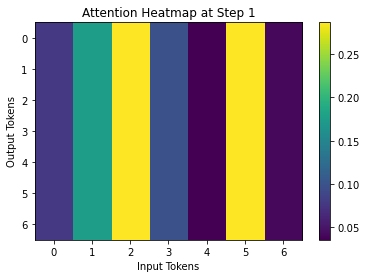

In [303]:
import matplotlib.pyplot as plt

# Function to generate text character-by-character given a prompt
def generate_text_character_by_character(model, start_string, num_generate=1000, temperature=1.0):
    # Convert the start string to tokens (character indices)
    input_eval = ids_from_chars(tf.strings.unicode_split(start_string, 'UTF-8'))
    input_eval = tf.expand_dims(input_eval, 0)

    # Initialize an empty string to store the generated text
    generated_text = start_string
    
    all_attention_weights = []

    # Low temperature generates more deterministic output,
    # high temperature generates more diverse output
    temperature = max(temperature, 0.1)

    # Generate text character-by-character
    model_states = None
    for _ in range(num_generate):
        # Get the model's predictions for the current input
        predictions, model_states, attention_weights = model(input_eval, states=model_states, return_state=True)

        # Remove the batch dimension from predictions
        predictions = tf.squeeze(predictions, 0)

        # Use the categorical distribution to sample the next character
        predictions /= temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Convert the predicted character index back to a string
        predicted_char = chars_from_ids(predicted_id)

        # Add the predicted character to the generated text
        generated_text += predicted_char.numpy().decode('utf-8')

        # Update the input_eval with the new character for the next iteration
        input_eval = ids_from_chars(tf.strings.unicode_split(generated_text, 'UTF-8'))
        input_eval = tf.expand_dims(input_eval, 0)
        
        all_attention_weights.append(attention_weights)


    return generated_text, all_attention_weights

# Test the character-by-character text generation function with a starting prompt
start_prompt = "Arthus"
generated_text, attention_weights = generate_text_character_by_character(model, start_string=start_prompt, num_generate=20, temperature=0.55)
print("Generated Text:")
print(generated_text)

print(attention_weights)

# Visualize the attention heatmap for a specific step (e.g., step 10)
step_to_visualize = 1
plt.imshow(attention_weights[step_to_visualize][0], cmap='viridis', aspect='auto')
plt.xlabel("Input Tokens")
plt.ylabel("Output Tokens")
plt.title("Attention Heatmap at Step {}".format(step_to_visualize))
plt.colorbar()
plt.show()
